# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1nCLw-s01rqSdxkOGdJ70tSVWi0mlUx96?usp=sharing

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [1]:
!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 41.5 MB/s eta 0:00:28tcmalloc: large alloc 1147494400 bytes == 0x3a6dc000 @  0x7f78d56dd615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |█████████████████               | 1055.7 MB 1.4 MB/s eta 0:11:15tcmalloc: large alloc 1434370048 bytes == 0x7ed32000 @  0x7f78d56dd615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |████

If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file = '/content/drive/My Drive/Colab Notebooks/aps360/Labs/Lab5/SMSSpamCollection'
hamMsg = False
spamMsg = False
for line in open(file):
    if line.split()[0] == "ham" and not hamMsg:
      print("It is a non-spam message: ")
      print(line)
      print("The label value for a non-spam message is: ")
      print(line.split()[0])
      print("----------------")
      hamMsg = True
    elif line.split()[0] == "spam" and not spamMsg:
      print("It is a spam message: ")
      print(line)
      print("The label value for a spam message is: ")
      print(line.split()[0])
      spamMsg = True
    if hamMsg and spamMsg:
      break

It is a non-spam message: 
ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

The label value for a non-spam message is: 
ham
----------------
It is a spam message: 
spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

The label value for a spam message is: 
spam


The label value for a spam message is "spam".

The label value for a non-spam message is "ham"

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [5]:
spam_count = 0
ham_count = 0
for line in open(file):
  if line.split()[0] == "spam":
      spam_count = spam_count+1
  elif line.split()[0] == "ham":
      ham_count = ham_count+1

print("The number of spam messages:", spam_count)
print("The number of non-spam messages:", ham_count)

The number of spam messages: 747
The number of non-spam messages: 4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

In [6]:
"""
Advantages:
1. It is more flexible and it can take mis-spelling into consideration.
2. It has smaller set of data to store and fewer letters/numbers/punctuation symbols, which requires less memory.

Disadvantages:
1. Lower accuracy because it can not get contextual information from neighbours. 
2. Higher computational cost because it requires a much bigger hidden layer to accurately model long-term dependencies.

"""

'\nAdvantages:\n1. It is more flexible and it can take mis-spelling into consideration.\n2. It has smaller set of data to store and fewer letters/numbers/punctuation symbols, which requires less memory.\n\nDisadvantages:\n1. Lower accuracy because it can not get contextual information from neighbours. \n2. Higher computational cost because it requires a much bigger hidden layer to accurately model long-term dependencies.\n\n'

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [7]:
import torchtext
import torch
from torchtext.legacy import data
from torchtext.legacy import datasets


text_field = torchtext.legacy.data.Field(sequential=True,
                  tokenize=lambda x: x, 
                  include_lengths=True, 
                  batch_first=True,
                  use_vocab=True)    
label_field = torchtext.legacy.data.Field(sequential=False,    
                  use_vocab=False,     
                  is_target=True,      
                  batch_first=True,
                  preprocessing=lambda x: int(x == 'spam'))
fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset(file,"tsv",fields)
train_set, valid_set, test_set = dataset.split(split_ratio=[0.6, 0.2, 0.2])
print("Total number of samples in dataset:", len(dataset))
print("Number of training samples:", len(train_set))
print("Number of val samples:", len(valid_set))
print("Number of testing samples:", len(test_set))


Total number of samples in dataset: 5572
Number of training samples: 3343
Number of val samples: 1115
Number of testing samples: 1114


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

If there are many more non-spam messages than spam messages in training set, the model would be biased towards labeling messages as ham. The model can make biased predictions by always predicting the sample to be of the larger category.

Having a balanced training set maybe helpful for training our neural network if sometimes we need bias to reduce negative effect, for example, misclassifying a spam email as ham is less harmful than misclassifying ham email as spam.

In [8]:
# save the original training examples
old_train_examples = train_set.examples
# get all the spam messages in `train`
train_spam = []
for item in train_set.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train_set.examples = old_train_examples + train_spam * 6

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [9]:
text_field.build_vocab(train_set)
print(text_field.vocab.stoi)
print(text_field.vocab.itos)
#text_field.vocab.stoi: a mapping of the character to a numeric identifier
#text_field.vocab.itos: a list of characters that can be accessed by indexing its numeric identifier in stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7ff9c8b6c2d0>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, '0': 13, 'h': 14, '.': 15, 'd': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, '2': 25, 'b': 26, '8': 27, 'T': 28, 'k': 29, 'v': 30, 'E': 31, 'S': 32, '5': 33, 'C': 34, 'O': 35, '7': 36, 'I': 37, '4': 38, 'N': 39, 'A': 40, 'x': 41, '3': 42, '6': 43, '!': 44, 'R': 45, ',': 46, 'P': 47, '9': 48, 'W': 49, 'M': 50, 'U': 51, 'H': 52, 'L': 53, 'F': 54, 'D': 55, 'G': 56, 'B': 57, 'Y': 58, "'": 59, '?': 60, '/': 61, '£': 62, '-': 63, '&': 64, ':': 65, 'z': 66, 'V': 67, 'X': 68, 'K': 69, '*': 70, 'j': 71, ')': 72, 'J': 73, ';': 74, '+': 75, '(': 76, 'Q': 77, 'q': 78, '"': 79, '#': 80, '>': 81, '@': 82, '=': 83, 'Z': 84, 'ü': 85, 'Ü': 86, '|': 87, '\x92': 88, '‘': 89, '$': 90, '_': 91, '\x93': 92, '¡': 93, '“': 94, '%': 95, '–': 96, '…': 97, '<': 98,

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [10]:
# <unk> represents unknown tokens
# <pad> represents padding, which added to ensure all characters in the batch are the same length

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [11]:
train_iter = torchtext.legacy.data.BucketIterator(train_set,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [12]:
for batch in train_iter:
    break

count = 1
for batch in train_iter:
    if count>10:
      break
    else:
      print(f"[Batch {count}] [Max Sequence Length {len(batch.sms[0][0])}]")
      print("Batch number:", count, "max length is:", int(batch.sms[1][0]))
      sum = 0
      for message in range(0, len(batch.sms[1])):
        sum = sum + batch.sms[1][0] - batch.sms[1][message]
      print("Number of  tokens used in batch",count,":",int(sum))
      count = count+1

[Batch 1] [Max Sequence Length 43]
Batch number: 1 max length is: 43
Number of  tokens used in batch 1 : 14
[Batch 2] [Max Sequence Length 156]
Batch number: 2 max length is: 156
Number of  tokens used in batch 2 : 27
[Batch 3] [Max Sequence Length 152]
Batch number: 3 max length is: 152
Number of  tokens used in batch 3 : 0
[Batch 4] [Max Sequence Length 60]
Batch number: 4 max length is: 60
Number of  tokens used in batch 4 : 38
[Batch 5] [Max Sequence Length 47]
Batch number: 5 max length is: 47
Number of  tokens used in batch 5 : 5
[Batch 6] [Max Sequence Length 204]
Batch number: 6 max length is: 204
Number of  tokens used in batch 6 : 616
[Batch 7] [Max Sequence Length 151]
Batch number: 7 max length is: 151
Number of  tokens used in batch 7 : 0
[Batch 8] [Max Sequence Length 153]
Batch number: 8 max length is: 153
Number of  tokens used in batch 8 : 7
[Batch 9] [Max Sequence Length 136]
Batch number: 9 max length is: 136
Number of  tokens used in batch 9 : 24
[Batch 10] [Max Seq

## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [13]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [23]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        self.name = "RNN"
        super(RNN, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [15]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct, total = 0, 0
    for msg in data:
        output = model(msg.sms[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(msg.label.view_as(pred)).sum().item()
        total += msg.label.shape[0]
    
    return correct/total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [16]:
import matplotlib.pyplot as plt 

In [17]:
def train_RNN(model, train, valid, num_epochs, lr, bs):
    trainIter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=bs,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)   
    validIter = torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=bs,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)  
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for sms, label in train_iter:
            optimizer.zero_grad()
            pred = model(sms[0])
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()
            
        losses.append(float(loss))     
        
        epochs.append(epoch)
        train_acc.append(get_accuracy(model, trainIter))
        valid_acc.append(get_accuracy(model, validIter))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (epoch+1, loss, train_acc[-1], valid_acc[-1]))

    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1; Loss 0.698960; Train Acc 0.496317; Val Acc 0.851121
Epoch 2; Loss 0.699669; Train Acc 0.529710; Val Acc 0.826906
Epoch 3; Loss 0.687936; Train Acc 0.550663; Val Acc 0.808072
Epoch 4; Loss 0.695989; Train Acc 0.638566; Val Acc 0.757848
Epoch 5; Loss 0.686132; Train Acc 0.663938; Val Acc 0.737220
Epoch 6; Loss 0.665386; Train Acc 0.692912; Val Acc 0.698655
Epoch 7; Loss 0.704475; Train Acc 0.664921; Val Acc 0.470852
Epoch 8; Loss 0.658095; Train Acc 0.672942; Val Acc 0.460090
Epoch 9; Loss 0.651664; Train Acc 0.663611; Val Acc 0.443049
Epoch 10; Loss 0.630282; Train Acc 0.679162; Val Acc 0.449327
Epoch 11; Loss 0.617161; Train Acc 0.672942; Val Acc 0.434978
Epoch 12; Loss 0.695038; Train Acc 0.679817; Val Acc 0.443946
Epoch 13; Loss 0.688818; Train Acc 0.705353; Val Acc 0.533632
Epoch 14; Loss 0.485673; Train Acc 0.817155; Val Acc 0.776682
Epoch 15; Loss 0.488126; Train Acc 0.886888; Val Acc 0.908520
Epoch 16; Loss 0.545521; Train Acc 0.884924; Val Acc 0.943498
Epoch 17; Loss 0.

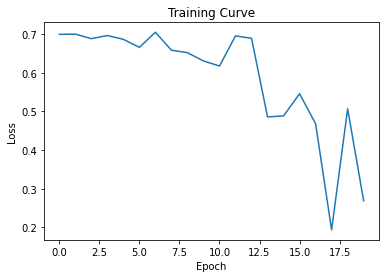

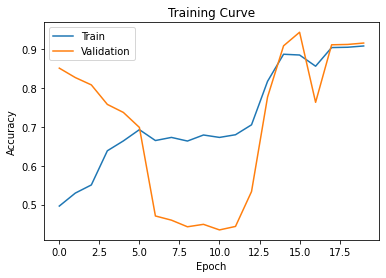

In [18]:
# number of input_size and hidden_size = len(text_field.vocab),num_classes = 2
model = RNN(len(text_field.vocab), len(text_field.vocab), 2)
epochs = 20
lr = 1e-5 # lr = 0.00001
bs = 32

train_RNN(model, train_set, valid_set, epochs, lr, bs)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

The 4 hyperparameters I will tune are the number of hidden layer, the RNN model, the batch size, and the learning rate.

Epoch 1; Loss 0.652196; Train Acc 0.527419; Val Acc 0.135426
Epoch 2; Loss 0.701541; Train Acc 0.527091; Val Acc 0.135426
Epoch 3; Loss 0.721264; Train Acc 0.526109; Val Acc 0.136323
Epoch 4; Loss 0.627039; Train Acc 0.526927; Val Acc 0.138117
Epoch 5; Loss 0.674409; Train Acc 0.528237; Val Acc 0.138117
Epoch 6; Loss 0.697555; Train Acc 0.530692; Val Acc 0.148879
Epoch 7; Loss 0.650478; Train Acc 0.561467; Val Acc 0.303139
Epoch 8; Loss 0.664087; Train Acc 0.569979; Val Acc 0.356054
Epoch 9; Loss 0.674771; Train Acc 0.602226; Val Acc 0.404484
Epoch 10; Loss 0.644003; Train Acc 0.632673; Val Acc 0.467265
Epoch 11; Loss 0.651907; Train Acc 0.655917; Val Acc 0.507623
Epoch 12; Loss 0.561461; Train Acc 0.692094; Val Acc 0.598206
Epoch 13; Loss 0.602470; Train Acc 0.812572; Val Acc 0.776682
Epoch 14; Loss 0.638594; Train Acc 0.843346; Val Acc 0.799103
Epoch 15; Loss 0.277395; Train Acc 0.870519; Val Acc 0.907623
Epoch 16; Loss 0.377690; Train Acc 0.879849; Val Acc 0.878924
Epoch 17; Loss 0.

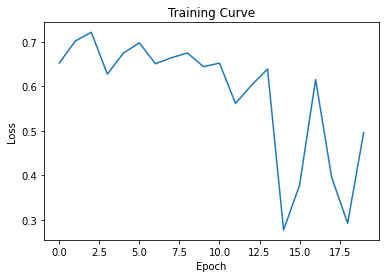

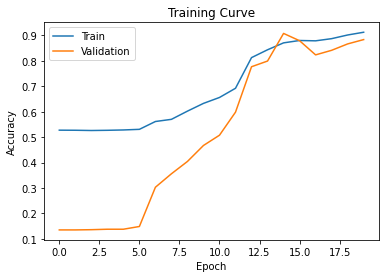

In [59]:
# First, change hidden_size into 100, the curve shows that the loss decreases a little bit
model = RNN(len(text_field.vocab), 100, 2)
epochs = 20
lr = 1e-5
bs = 32

train_RNN(model, train_set, valid_set, epochs, lr, bs)

In [60]:
# Secondly, keep the changed num of hidden_layer, and used a new RNN model with max pooling layer.
# The curves show that the loss increases and the accuracy decreases
class newRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        self.name = "newRNN"
        super(newRNN, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(torch.max(out, dim=1)[0])
        return out

Epoch 1; Loss 0.358055; Train Acc 0.906531; Val Acc 0.917489
Epoch 2; Loss 0.311133; Train Acc 0.911933; Val Acc 0.912108
Epoch 3; Loss 0.322193; Train Acc 0.910951; Val Acc 0.864574
Epoch 4; Loss 0.312834; Train Acc 0.918481; Val Acc 0.921076
Epoch 5; Loss 0.129876; Train Acc 0.932559; Val Acc 0.922870
Epoch 6; Loss 0.377696; Train Acc 0.925683; Val Acc 0.921973
Epoch 7; Loss 0.314165; Train Acc 0.933704; Val Acc 0.913004
Epoch 8; Loss 0.212458; Train Acc 0.905385; Val Acc 0.859193
Epoch 9; Loss 0.221164; Train Acc 0.933541; Val Acc 0.917489
Epoch 10; Loss 0.146351; Train Acc 0.931740; Val Acc 0.909417
Epoch 11; Loss 0.696794; Train Acc 0.937633; Val Acc 0.918386
Epoch 12; Loss 0.124411; Train Acc 0.935832; Val Acc 0.918386
Epoch 13; Loss 0.145944; Train Acc 0.940907; Val Acc 0.928251
Epoch 14; Loss 0.379194; Train Acc 0.939597; Val Acc 0.919283
Epoch 15; Loss 0.342199; Train Acc 0.933868; Val Acc 0.919283
Epoch 16; Loss 0.215368; Train Acc 0.940252; Val Acc 0.923767
Epoch 17; Loss 0.

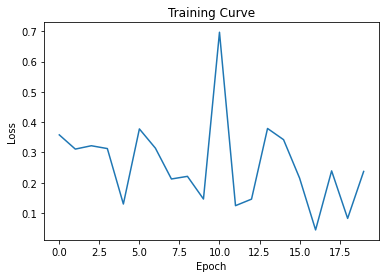

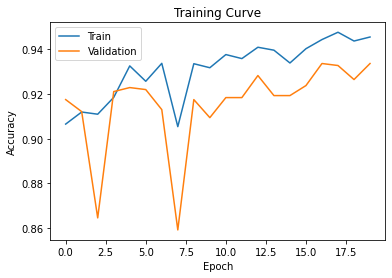

In [61]:
model2 = newRNN(len(text_field.vocab), 100, 2)
epochs = 20
lr = 1e-5
bs = 32

train_RNN(model, train_set, valid_set, epochs, lr, bs)

Epoch 1; Loss 0.115882; Train Acc 0.939270; Val Acc 0.914798
Epoch 2; Loss 0.058271; Train Acc 0.946472; Val Acc 0.920179
Epoch 3; Loss 0.225137; Train Acc 0.946472; Val Acc 0.922870
Epoch 4; Loss 0.503394; Train Acc 0.944672; Val Acc 0.918386
Epoch 5; Loss 0.206860; Train Acc 0.949746; Val Acc 0.921076
Epoch 6; Loss 0.533967; Train Acc 0.942053; Val Acc 0.913004
Epoch 7; Loss 0.364235; Train Acc 0.948273; Val Acc 0.923767
Epoch 8; Loss 0.260672; Train Acc 0.950401; Val Acc 0.924664
Epoch 9; Loss 0.227514; Train Acc 0.944835; Val Acc 0.917489
Epoch 10; Loss 0.298909; Train Acc 0.952856; Val Acc 0.925561
Epoch 11; Loss 0.030145; Train Acc 0.953675; Val Acc 0.930942
Epoch 12; Loss 0.315392; Train Acc 0.947127; Val Acc 0.925561
Epoch 13; Loss 0.017076; Train Acc 0.953839; Val Acc 0.931839
Epoch 14; Loss 0.151805; Train Acc 0.938943; Val Acc 0.916592
Epoch 15; Loss 0.102836; Train Acc 0.956130; Val Acc 0.933632
Epoch 16; Loss 0.155876; Train Acc 0.957767; Val Acc 0.942601
Epoch 17; Loss 0.

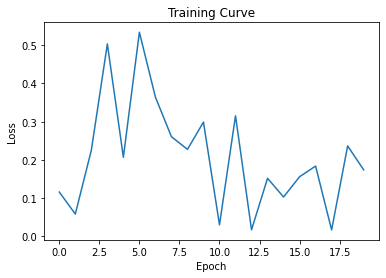

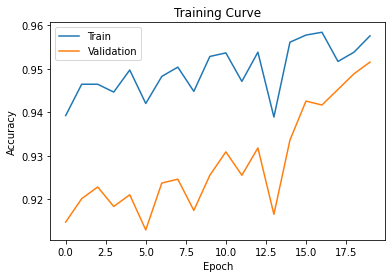

In [62]:
# Thirdly, use the original RNN and change batch size into 64, the curves show that loss decreases
model3 = RNN(len(text_field.vocab), 100, 2)
epochs = 20
lr = 1e-5
bs = 64

train_RNN(model, train_set, valid_set, epochs, lr, bs)

Epoch 1; Loss 0.015146; Train Acc 0.975119; Val Acc 0.976682
Epoch 2; Loss 0.101659; Train Acc 0.976428; Val Acc 0.973991
Epoch 3; Loss 0.099169; Train Acc 0.975282; Val Acc 0.972197
Epoch 4; Loss 0.023463; Train Acc 0.975282; Val Acc 0.973094
Epoch 5; Loss 0.065103; Train Acc 0.977410; Val Acc 0.971300
Epoch 6; Loss 0.168653; Train Acc 0.977901; Val Acc 0.969507
Epoch 7; Loss 0.019577; Train Acc 0.977410; Val Acc 0.969507
Epoch 8; Loss 0.016446; Train Acc 0.977574; Val Acc 0.971300
Epoch 9; Loss 0.009228; Train Acc 0.978065; Val Acc 0.970404
Epoch 10; Loss 0.026761; Train Acc 0.978393; Val Acc 0.969507
Epoch 11; Loss 0.012425; Train Acc 0.978393; Val Acc 0.970404
Epoch 12; Loss 0.077521; Train Acc 0.977738; Val Acc 0.972197
Epoch 13; Loss 0.108342; Train Acc 0.977574; Val Acc 0.971300
Epoch 14; Loss 0.018182; Train Acc 0.977901; Val Acc 0.971300
Epoch 15; Loss 0.020719; Train Acc 0.977738; Val Acc 0.972197
Epoch 16; Loss 0.013001; Train Acc 0.978065; Val Acc 0.970404
Epoch 17; Loss 0.

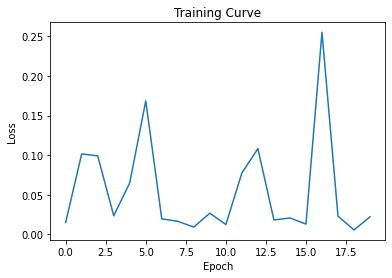

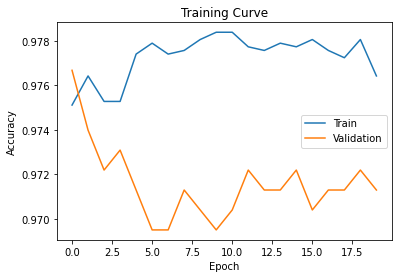

In [65]:
# Fourthly, change learning rate into 0.000001,the loss decreases and the accuracy increases. 
# The curves are very unstable and the valid accuracy decreases
model4 = RNN(len(text_field.vocab), len(text_field.vocab), 2)
epochs = 20
lr = 0.000001
bs = 32

train_RNN(model, train_set, valid_set, epochs, lr, bs)

The model3 is the best model and the best validation accuracy is 0.951570

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [74]:
torch.save(model3.state_dict(), "/content/model3")

In [73]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid_set.examples if e.label == 1],
    valid_set.fields)
valid_spam_iter = torchtext.legacy.data.BucketIterator(valid_spam,batch_size=32,sort_key=lambda x: len(x.sms),sort_within_batch=True,repeat=False)   
               # repeat the iterator for many epochs
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in valid_set.examples if e.label == 0],
    valid_set.fields)
valid_nospam_iter = torchtext.legacy.data.BucketIterator(valid_nospam,batch_size=32,sort_key=lambda x: len(x.sms),sort_within_batch=True,repeat=False)                  # repeat the iterator for many epochs

final_model = RNN(len(text_field.vocab), 100, 2)
state = torch.load("model3")
final_model.load_state_dict(state)

false_positive_rate = 1 - get_accuracy(model3, valid_nospam_iter)
false_negative_rate = 1 - get_accuracy(model3, valid_spam_iter)
print("The model's false positive rate is {}.".format(false_positive_rate))
print("The model's false negative rate is {}.".format(false_negative_rate))

The model's false positive rate is 0.024870466321243567.
The model's false negative rate is 0.06000000000000005.


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

False negative(spam labeled as non-spam) would make the users feel annoying because it sent the spam message to the users. False positive (non-spam labeled as spam) would cause bad influence because user may miss the useful information.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [58]:
test_iter = torchtext.legacy.data.BucketIterator(test_set,batch_size=64,sort_key=lambda x: len(x.sms),sort_within_batch=True,repeat=False)
print("The final test accuracy of my model is {}.".format(get_accuracy(model3, test_iter)))

The final test accuracy of my model is 0.9703770197486535.


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [79]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test_set.examples if e.label == 1],
    test_set.fields)

test_spam_iter = torchtext.legacy.data.BucketIterator(valid_spam,batch_size=64,sort_key=lambda x: len(x.sms),sort_within_batch=True,repeat=False)   
               # repeat the iterator for many epochs
# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.legacy.data.Dataset(
    [e for e in test_set.examples if e.label == 0],
    test_set.fields)
test_nospam_iter = torchtext.legacy.data.BucketIterator(valid_nospam,batch_size=64,sort_key=lambda x: len(x.sms),sort_within_batch=True,repeat=False)                  # repeat the iterator for many epochs

final_model = RNN(len(text_field.vocab), 100, 2)
state = torch.load("model3")
final_model.load_state_dict(state)

false_positive_rate = 1 - get_accuracy(model3, test_nospam_iter)
false_negative_rate = 1 - get_accuracy(model3, test_spam_iter)
print("The model's false positive rate is {}.".format(false_positive_rate))
print("The model's false negative rate is {}.".format(false_negative_rate))

The model's false positive rate is 0.021761658031088094.
The model's false negative rate is 0.06000000000000005.


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [92]:
msg = "machine learning is sooo cool!"
msg_tokens = []
for char in msg:
  msg_tokens.append(torch.tensor(text_field.vocab.stoi[char]))
x = torch.stack(msg_tokens)
x.unsqueeze_(0)
print("The probability that the SMS message is spam is {}.".format(F.softmax(model3(x), dim=1)[0][1].item()))
print("The probability that the SMS message is ham is {}.".format(F.softmax(model3(x), dim=1)[0][0].item()))

The probability that the SMS message is spam is 0.22144411504268646.
The probability that the SMS message is ham is 0.7785558700561523.


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

The classification of spam messages is easy, since a not complex RNN that trained quickly can easily achieve a high accuracy rate within a short period of time. However, the model is better at detecting non-spam messages than spam messages, which can be demostrated by higher false negative and lower false positive rates.

A simple baseline model can be a word level model based on the frequency of the words. Typically, spam messages contain many exclamation marks, dollar signs, money-related or misspelled words. Therefore, these words like "dollars", "reward", "money" which are more likely to appear in spam messages should be taken into consideration. The baseline model could predict whether a message is spam based on the most frequent word in the message compared to a list of words which appear most in spam message.